# Tutorial <span style='color:red'>?</span>: Small Angle Neutron Scattering

Small Angle Neutron Scattering (SANS) is a powerful reciprocal space technique that can be used to investigate magnetic structures on mesoscopic length scales. In SANS the atomic structure generally has a minimal impact hence the sample can be approximated by a continuous magnetisation vector field \[[Mühlbauer 2019](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004)\].

The differential scattering cross section $d\Sigma/d\Omega$ can be used as a function of the scattering vector ${\bf q}$ to predict the scattering patterns produced. The scattering can be calculated with the use of the magnetic interaction vector  ${\bf Q}$ \[[Mühlbauer 2019](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004)\] where

\begin{equation}
    {\bf Q} = \hat{\bf q} \times \left[ \widetilde{\bf M} \times \hat{\bf q} \right],
\end{equation}
where $\hat{\bf q}$ is the unit scattering vector and $\widetilde{\bf M}$ is the Fourier transform of the magnetisation.

The scattering vector is defined as 
\begin{equation}
    {\bf q} = {\bf k}_1 - {\bf k}_0
\end{equation}
where ${\bf k}_0$ and ${\bf k}_1$ are the incident and scattered wavevectors respectively.

## SANS Reference frame

In `mag2exp` the SANS reference frame is the same as that defined to be the same as the same as the sample reference frame. The neutron polarisation direction can then be defined relative to the sample reference frame.

<img src="Figures/SANS.png" width="900" height="600">

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure with periodic boundary conditions in the $xy$ plane.

c:\users\samjr_ym2i32\onedrive - university of warwick\ubermag_pd\ubermag_dev\discretisedfield\discretisedfield\field.py:126: UserWarning: Component labels must be specified for dim=1 fields to get access to individual vector components.
  warnings.warn(f'Component labels must be specified for {dim=}'


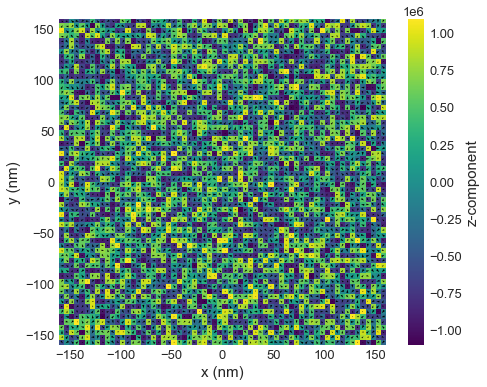

In [1]:
# NBVAL_IGNORE_OUTPUT
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-160e-9, -160e-9, 0), p2=(160e-9, 160e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='xyz')

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Relax the system and plot its magnetisation.

Running OOMMF (DockerOOMMFRunner) [2021/09/04 10:00]... (140.4 s)


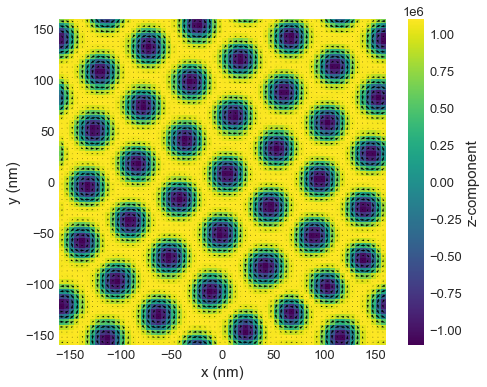

In [2]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

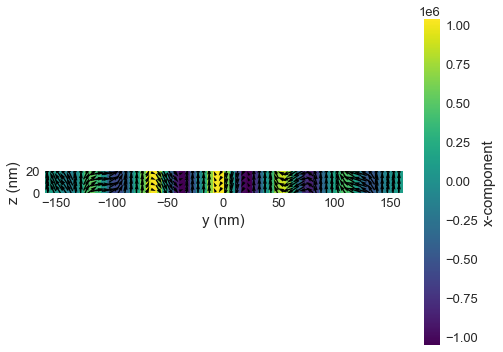

In [3]:
system.m.plane('x').mpl()

Now we have a magnetisation texture we can compute the SANS scattering cross sections.

## Computing SANS Cross-sections

We can use the `mag2exp` package to calculate the cross sections. First the geometry has to be chosen, then for this geometry the magnetic interaction vector  ${\bf Q}$ is calculated. From this the magnetic contribution to the cross sections can be calculated as

\begin{equation}
 \frac{d\sum}{d\Omega} \sim |{\bf Q} \cdot {\bf \sigma}|^2,
\end{equation}
where ${\bf \sigma}$ is the Pauli vector 
\begin{equation}
    {\bf \sigma} = \begin{bmatrix} \sigma_x \\ \sigma_y \\ \sigma_z \end{bmatrix},
\end{equation}
and 
\begin{align}
    \sigma_x &= \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \\
    \sigma_y &= \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \\
    \sigma_z &= \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}.
\end{align}


For a polarisation in an arbitrary direction the Pauli vector can be rotated.

This takes the form
\begin{equation}
 \frac{d\sum}{d\Omega} = \begin{pmatrix}
                            \frac{d\sum^{++}}{d\Omega} & \frac{d\sum^{-+}}{d\Omega}\\
                            \frac{d\sum^{+-}}{d\Omega} & \frac{d\sum^{--}}{d\Omega}
                         \end{pmatrix}
\end{equation}

These then be combined in order to get the half and unpolarised cross sections.

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

For example the unpolarised cross section calculated with the polarisation along the $z$ direction.

In [4]:
import mag2exp

In [5]:
cross_section = mag2exp.sans.cross_section2(system.m, method='unpol', polarisation=[0,0,1])

The `mag2exp.sans.cross_section` function produces a three dimentional cross section. This cross section can then be cut for the relevant scattering plane. Here the `z=0` scattering plane is used, this is equivalent to the incoming neutron beam being parallel to the $z$ direction.

As the cross section is a `discretisedfield` object the built in plotting functions can be used to view them.
The cross section is a complex quantity, hence to view it either the real or imaginary part or the norm has to be selected before plotting.

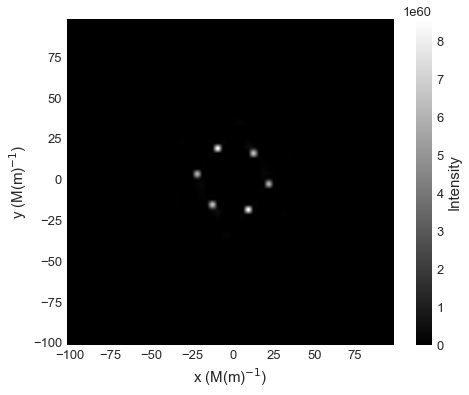

In [6]:
# NBVAL_IGNORE_OUTPUT
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16',
                                    colorbar_label=r'Intensity')

Due to the high intensity of some areas a linear colour map make some features more difficult to see. We can use `matplotlib.color` to change the colour bar to a logarithmic scale. This 
reveals the higher order low intensity diffraction peaks. 

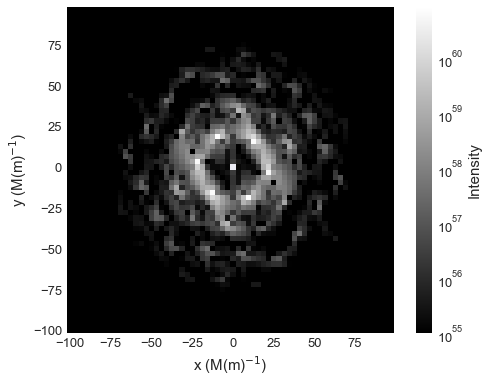

In [7]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.colors as colors
cross_section.plane(z=0).mpl.scalar(cmap='gray',
                                    colorbar_label=r'Intensity', 
                                    norm=colors.LogNorm(vmin=1e55,vmax=cross_section.real.array.max()))

It is also possible to just plot a selected region of the cross section by

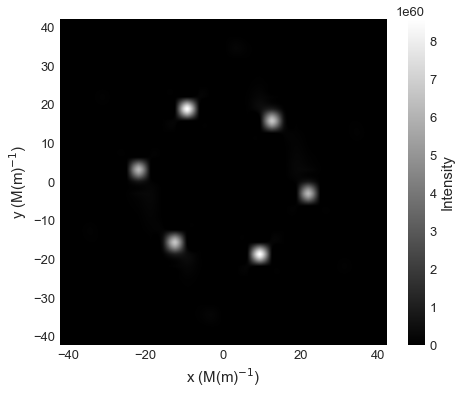

In [8]:
# NBVAL_IGNORE_OUTPUT
sans_region = df.Region(p1=(-40e6, -40e6, 0), p2=(40e6, 40e6, 0.5))
cross_section.plane(z=0)[sans_region].mpl.scalar(cmap='gray', interpolation='spline16',
                                                 colorbar_label=r'Intensity')

For this in the parallel scattering geometry the spin-flip cross sections are

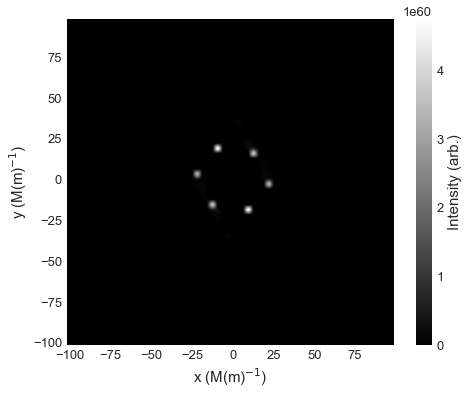

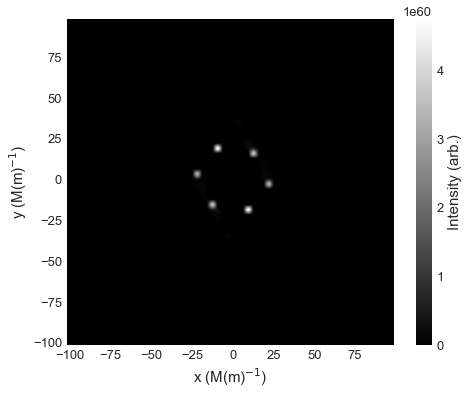

In [9]:
# NBVAL_IGNORE_OUTPUT
cross_section = mag2exp.sans.cross_section2(system.m, method='pn', polarisation=[0,0,1])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = mag2exp.sans.cross_section2(system.m, method='np', polarisation=[0,0,1])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

and non-spin-flip cross sections are

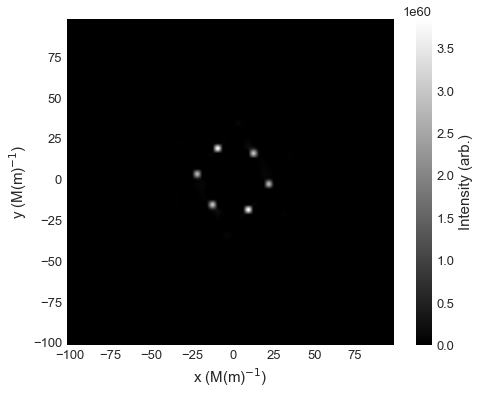

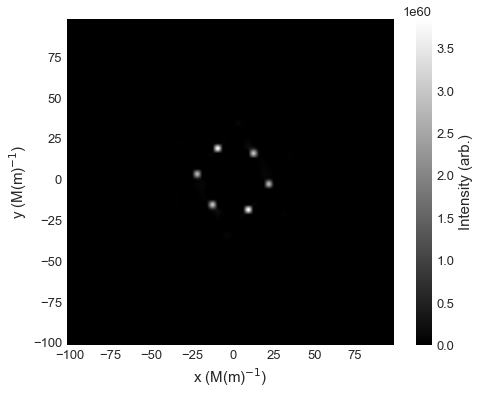

In [10]:
# NBVAL_IGNORE_OUTPUT
cross_section = mag2exp.sans.cross_section2(system.m, method='pp', polarisation=[0,0,1])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = mag2exp.sans.cross_section2(system.m, method='nn', polarisation=[0,0,1])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

We can also look at the scattering geometry where the beam and polarisation are no longer parallel.

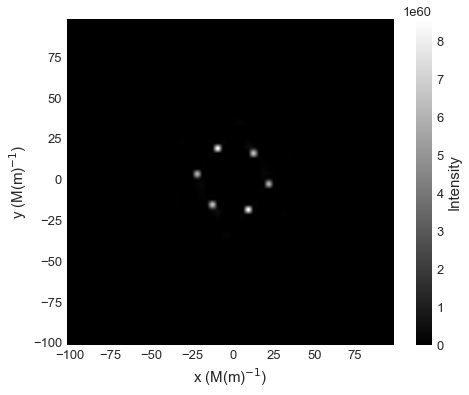

In [11]:
# NBVAL_IGNORE_OUTPUT
cross_section = mag2exp.sans.cross_section2(system.m, method='unpol', polarisation=[1,0,0])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', 
                                    colorbar_label=r'Intensity')

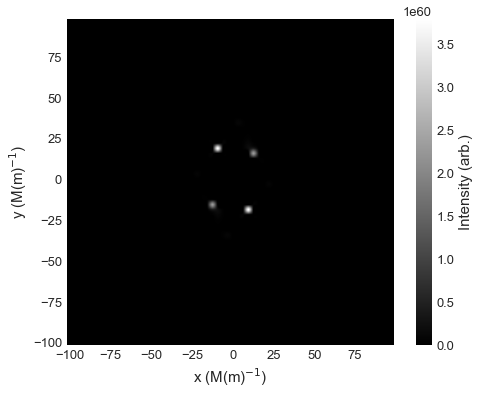

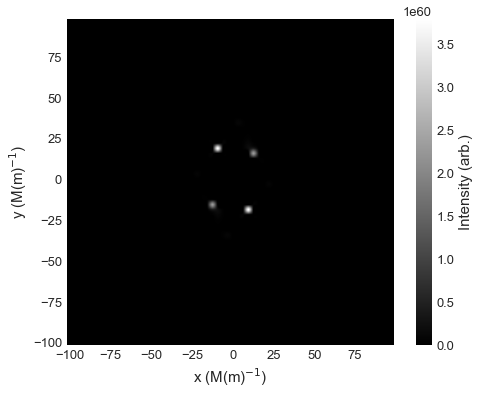

In [12]:
cross_section = mag2exp.sans.cross_section2(system.m, method='pp', polarisation=[1,0,0])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = mag2exp.sans.cross_section2(system.m, method='nn', polarisation=[1,0,0])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

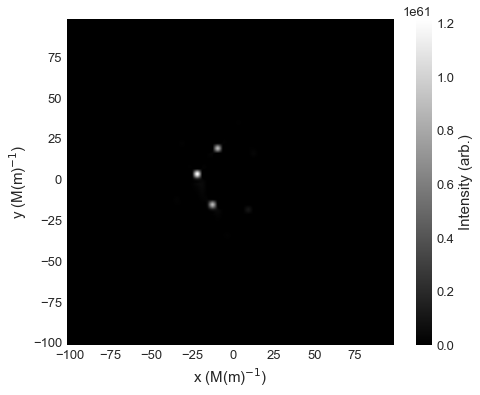

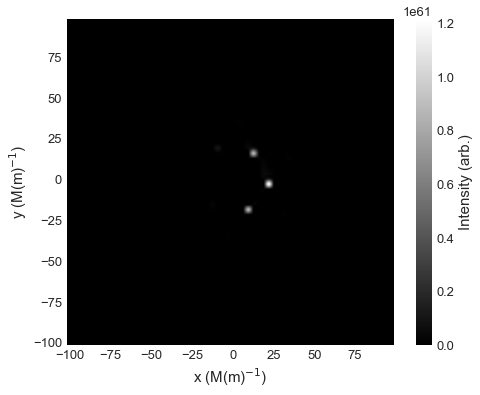

In [13]:
cross_section = mag2exp.sans.cross_section2(system.m, method='pn', polarisation=[1,0,0])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = mag2exp.sans.cross_section2(system.m, method='np', polarisation=[1,0,0])
cross_section.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

It is possible to examine the chiral function as well

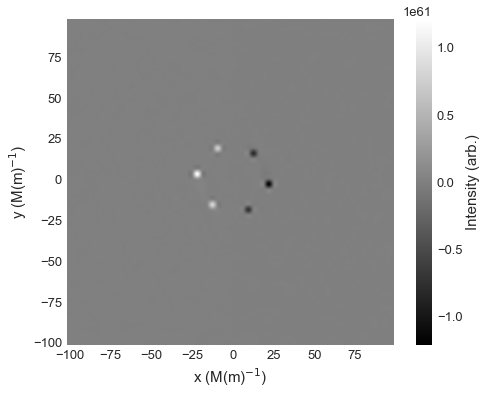

In [14]:
chiral = mag2exp.sans.chiral_function2(system.m, polarisation=[1,0,0])
chiral.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')